In [70]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, log_loss
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from IPython.display import display, Markdown
% matplotlib inline

## Step 1: Open dataset and only select those faces for which we have 70 or more images.

In [127]:
lfw = glob.glob('./lfw/*')
folder_list = []
for folder in lfw:
    if len(glob.glob(folder + '/*.jpg')) >= 70:
        folder_list.append(folder.split('/')[-1])
folder_list

['Ariel_Sharon',
 'Colin_Powell',
 'Donald_Rumsfeld',
 'George_W_Bush',
 'Gerhard_Schroeder',
 'Hugo_Chavez',
 'Tony_Blair']

In [27]:
lfw = datasets.fetch_lfw_people(min_faces_per_person=70, 
                                resize=0.4,
                                data_home='datasets')

## Step 2: Print a few of the faces to familiarized yourself with the data.

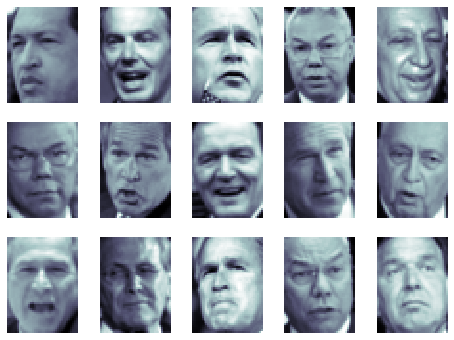

In [28]:
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw.images[i], cmap=plt.cm.bone)

## Step 3: Graph the different labels vs their count.

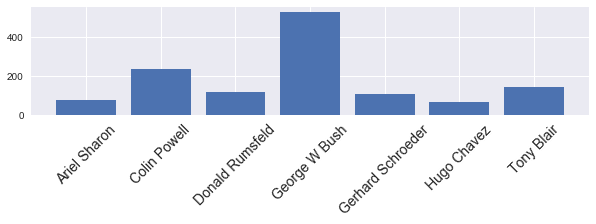

In [29]:
plt.figure(figsize=(10, 2))
unique_targets = np.unique(lfw.target)
counts = [(lfw.target == i).sum() for i in unique_targets]
plt.xticks(unique_targets, lfw.target_names[unique_targets])
locs, labels = plt.xticks()
plt.setp(labels, rotation=45, size=14)
_ = plt.bar(unique_targets, counts)

## Step 4: Notice that the number of features in our dataset is fairly large. This is a good moment to apply PCA to reduce the dimensionality of our dataset. Lets choose 150 components.

In [38]:
n_samples, h, w = lfw.images.shape
X = lfw.data
n_features = X.shape[1]
y = lfw.target
target_names = lfw.target_names
n_classes = target_names.shape[0]

In [39]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

In [43]:
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Extracting the top 150 eigenfaces from 966 faces
Projecting the input data on the eigenfaces orthonormal basis


## Step 5: A really cool thing about PCA is that it lets you compute the mean of each entry which we can then use to obtain the 'average' face in our dataset.

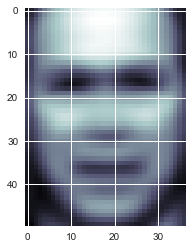

In [44]:
plt.imshow(pca.mean_.reshape((50, 37)), cmap=plt.cm.bone)

## Step 6: Plot the components of the PCA. Notice that these are always ordered by importance.

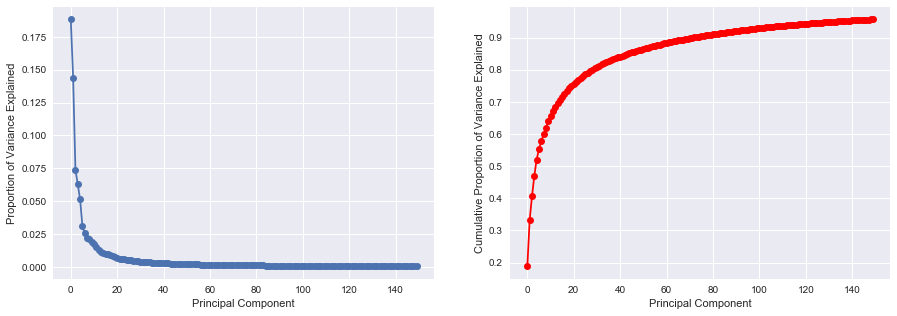

In [46]:
# more compact representation of principal components
fig ,(ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

# Left plot
ax1.plot(pca.explained_variance_ratio_, '-o')
ax1.set_ylabel('Proportion of Variance Explained')

# Right plot
ax2.plot(np.cumsum(pca.explained_variance_ratio_), '-ro')
ax2.set_ylabel('Cumulative Proportion of Variance Explained')

for ax in fig.axes:
    ax.set_xlabel('Principal Component')

# Exercise 2:

### Logistic Regression

In [60]:
lr = LogisticRegression()
lr.fit(X_train_pca, y_train)
print(f"Logistic Regression Prediction Accuracy: {round(lr.score(X_test_pca, y_test)*100,2)}%")
print(f"Logistic Regression Error rate: {round((1 - lr.score(X_test_pca, y_test))*100,2)}%")

Logistic Regression Prediction Accuracy: 79.81%
Logistic Regression Error rate: 20.19%


### kNeighbors Classifier

In [62]:
best_k_value = 0
best_accuracy = 0
for k in range(1,20):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    pred = knn.fit(X_train_pca, y_train).predict(X_test_pca)
    if round(knn.score(X_test_pca, y_test),3)*100 > best_accuracy:
        best_k_value = k
        best_accuracy = round(knn.score(X_test_pca, y_test),3)*100

knn = neighbors.KNeighborsClassifier(n_neighbors=best_k_value)
knn.fit(X_train_pca, y_train).predict(X_test_pca)
print(f"KNN Prediction Accuracy: {round(knn.score(X_test_pca, y_test)*100,2)}%, using {best_k_value} neighbors")
print(f"KNN Error rate: {round((1 - knn.score(X_test_pca, y_test))*100,2)}%, using {best_k_value} neighbors")

KNN Prediction Accuracy: 69.88%, using 8 neighbors
KNN Error rate: 30.12%, using 8 neighbors


### Linear Discriminant

In [63]:
lda = LDA()
lda.fit(X_train_pca, y_train)
print(f"LDA Prediction Accuracy: {round(lda.score(X_test_pca, y_test)*100,2)}%")
print(f"LDA Error rate: {round((1 - lda.score(X_test_pca, y_test))*100,2)}%")

LDA Prediction Accuracy: 81.99%
LDA Error rate: 18.01%


### Naive Bayes

In [64]:
nb = GaussianNB()
nb.fit(X_train_pca, y_train)
print(f"NB Prediction Accuracy: {round(nb.score(X_test_pca, y_test)*100,2)}%")
print(f"NB Error rate: {round((1 - nb.score(X_test_pca, y_test))*100,2)}%")

NB Prediction Accuracy: 67.39%
NB Error rate: 32.61%


### Part 2: Which one had the best performance? Which one had the worst performance?

LR > LDA > KNN > NB

### Part 3: Any idea why the score on the top two differs so drastically from the last two?

They are linear-based

### Part 4: Find the log_loss, precision, recall, f_score of the best model.

In [92]:
print(f"Log loss: {log_loss(y_test, lr.predict_proba(X_test_pca))}")
print(classification_report(y_test, lr.predict(X_test_pca), digits=3, target_names=target_names))

Log loss: 0.8024467339935007
                   precision    recall  f1-score   support

     Ariel Sharon      0.900     0.643     0.750        28
     Colin Powell      0.779     0.841     0.809        63
  Donald Rumsfeld      0.739     0.708     0.723        24
    George W Bush      0.892     0.879     0.885       132
Gerhard Schroeder      0.467     0.700     0.560        20
      Hugo Chavez      0.923     0.545     0.686        22
       Tony Blair      0.711     0.818     0.761        33

      avg / total      0.817     0.798     0.800       322



### Part 5: Plot the Confusion Matrix of the best model.

In [99]:
print(confusion_matrix(y_test, lr.predict(X_test_pca), labels=range(n_classes)))

[[ 18   4   1   1   4   0   0]
 [  2  53   2   1   0   1   4]
 [  0   2  17   4   0   0   1]
 [  0   7   2 116   4   0   3]
 [  0   0   1   2  14   0   3]
 [  0   1   0   4   5  12   0]
 [  0   1   0   2   3   0  27]]


In [126]:
cfm = pd.DataFrame(confusion_matrix(y_test, lr.predict(X_test_pca), labels=range(n_classes)))
cfm.columns = target_names
cfm.index = target_names

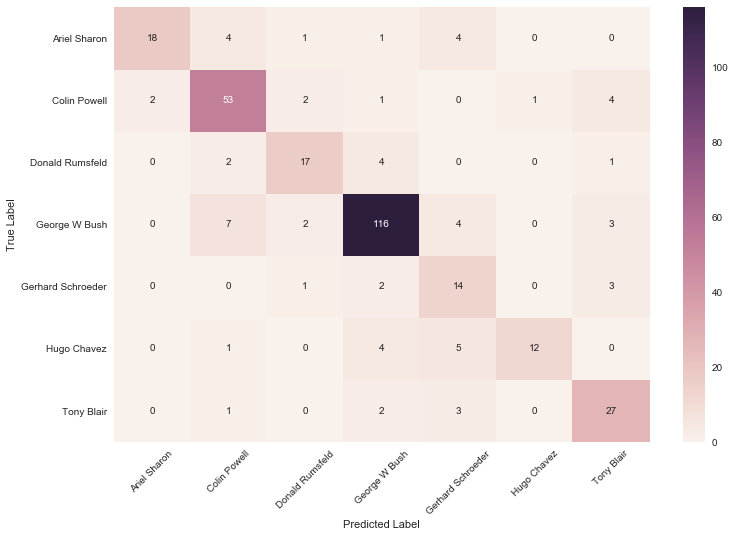

In [128]:
fig = plt.figure(figsize=(12,8))
sns.heatmap(cfm, annot=True, fmt='d')
plt.xticks(rotation=45)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Slightly more interpretable accuracy percentage:

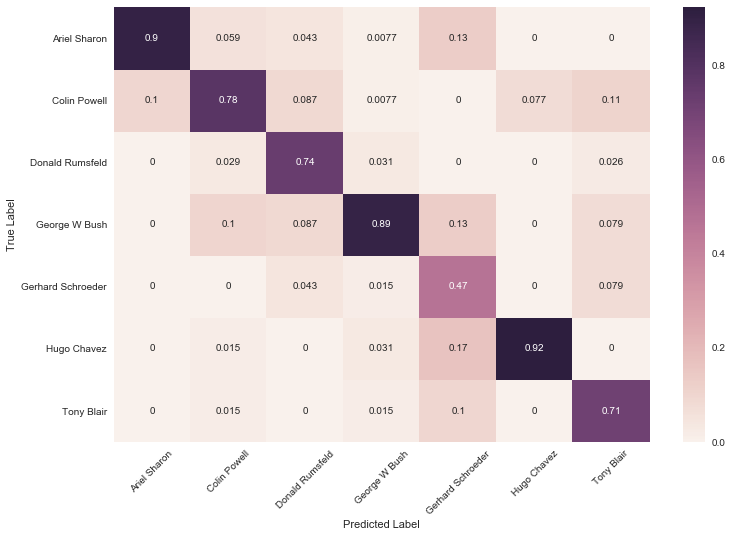

In [135]:
cfm_scaled = cfm [:]
for col in cfm.columns:
    cfm_scaled[col] = cfm[col].apply(lambda x: x/cfm[col].sum())
fig = plt.figure(figsize=(12,8))
sns.heatmap(cfm_scaled, annot=True)
plt.xticks(rotation=45)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Part 6 (optional): Edit the code from *Step 2* to display not only the image but also the label and color code the label in red if your model got it wrong or black if it got it right.

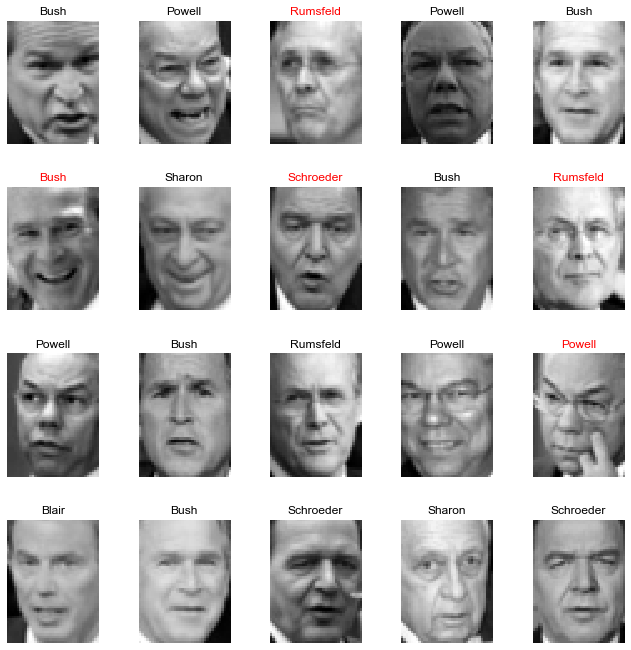

In [107]:
def plot_gallery(images, titles, h, w, n_row=4, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i][0], color=titles[i][1], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    if pred_name == true_name: color = 'black'
    else: color = 'red'
    return ['%s' % (true_name), color]

prediction_titles = [title(lr.predict(X_test_pca), y_test, target_names, i)
                     for i in range(lr.predict(X_test_pca).shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

plt.show()